Import Libraries 

In [31]:
from google import genai
import matplotlib.pyplot as plt
import re
import random

Experimental setup

In [32]:
n_testcases = 20 # Number of test cases for each code iteration
n_iterations = 10 # Number of iterations for each LLM
code_iterations = []

Helper functions

In [ ]:
def StringToData(text: str):
    # Converts a string of test cases into a list of dictionaries #
    testcases = []

    lines = text.strip().split('\n')
    for line in lines:
        line = line.strip()
        if "Input:" in line and "Output:" in line:
            parts = line.split("Output:")
            input_part = parts[0].replace("Input:", "").strip()
            output_part = parts[1].strip()

            input_values = [float(x.strip()) for x in input_part.split(',')]
            output_value = output_part

            testcases.append({
                "input": input_values,
                "output": output_value
            })

    return testcases

def getTestCases(n_cases: int):
    # Gets a list of random testcases from testcases.txt (generated by CartPole_DQN) #
    text_input = """"""
    with open('testcases.txt', 'r') as file:
        lines = file.readlines()
        r_lines = random.sample(lines, n_cases)  
        for line in r_lines:
            text_input += line.strip() + "\n"
    
    #print(text_input)
    testcases = StringToData(text_input)
    #print(testcases)

    return testcases

def DataToString(data_points: list[dict]):
    # Gets testcases as a list of dictionaries and converts it back into a single string #
    lines = []
    for point in data_points:
        input_line = "Input: " + ", ".join(str(x) for x in point["input"])
        output_line = f"Output: {point['output']}"
        lines.append(input_line)
        lines.append(output_line)

    return "\n".join(lines)

def queryLLMfirst(testcases):
    # Querys LLM (Gemini) using test cases as examples and returns the generated code #
    
    client = genai.Client(api_key="<api key goes here>")
    response = client.models.generate_content(
        model="gemini-2.0-flash", 
        contents= """Generate a small python function that takes 4 parameters using programming by example (only respond with code, no explanation, no comments):\n""" + testcases 
    )

    return response.text

def queryLLM(code_to_evolve, fail_cases):
    # Querys LLM (Gemini) to evolve current function using FAILED test cases and returns the result #
    client = genai.Client(api_key="<api key goes here>")
    response = client.models.generate_content(
        model="gemini-2.0-flash", 
        contents="""This current implementation of a python function is flawed:\n""" + code_to_evolve + 
                 """\nModify the function so that it gives the correct output for the following failed test cases (respond only with the new code):\n""" + DataToString(fail_cases)
    )
    #print(response.text)
    return response.text

def stripCode(initial_code):
    # Gets the generated python code and removes all markdown styling. #
    generated_code = re.search(r"```python\s*\n([\s\S]+?)\n```", initial_code, re.S)
    updated_function = generated_code.group(1).strip()

    return updated_function

def runCode(code_to_run, parameters):
    # Runs the current code iteration with the parameters from the test cases. #
    cp = parameters[0]
    cv = parameters[1]
    pa = parameters[2]
    pv = parameters[3]
    
    local_scope = {}
    exec(code_to_run, globals(), local_scope)

    func = list(local_scope.values())[0]
    result = func(cp, cv, pa, pv)

    return result

Begin experiment with first code iteration

In [34]:
testcases = (getTestCases(n_testcases)) # Get testcases from text file
generated_code = queryLLMfirst(DataToString(testcases)) # Get first iteration of code
first_iteration = stripCode(generated_code) # Strip markdown from the generated code
print(first_iteration) # Show the first iteration of code
code_iterations.append(first_iteration) # Save first iteration

def check_direction(a, b, c, d):
  if d > 0:
    return "RIGHT"
  else:
    return "LEFT"


Testing loop 


Test case 1:
LLM Code: RIGHT
Neural Network: RIGHT
Passed

Test case 2:
LLM Code: RIGHT
Neural Network: RIGHT
Passed

Test case 3:
LLM Code: RIGHT
Neural Network: RIGHT
Passed

Test case 4:
LLM Code: RIGHT
Neural Network: LEFT
Failed

Test case 5:
LLM Code: RIGHT
Neural Network: LEFT
Failed

Test case 6:
LLM Code: LEFT
Neural Network: LEFT
Passed

Test case 7:
LLM Code: LEFT
Neural Network: LEFT
Passed

Test case 8:
LLM Code: RIGHT
Neural Network: RIGHT
Passed

Test case 9:
LLM Code: RIGHT
Neural Network: RIGHT
Passed

Test case 10:
LLM Code: RIGHT
Neural Network: RIGHT
Passed

Test case 11:
LLM Code: RIGHT
Neural Network: RIGHT
Passed

Test case 12:
LLM Code: LEFT
Neural Network: LEFT
Passed

Test case 13:
LLM Code: RIGHT
Neural Network: RIGHT
Passed

Test case 14:
LLM Code: LEFT
Neural Network: LEFT
Passed

Test case 15:
LLM Code: LEFT
Neural Network: LEFT
Passed

Test case 16:
LLM Code: LEFT
Neural Network: LEFT
Passed

Test case 17:
LLM Code: RIGHT
Neural Network: RIGHT
Passed

Te

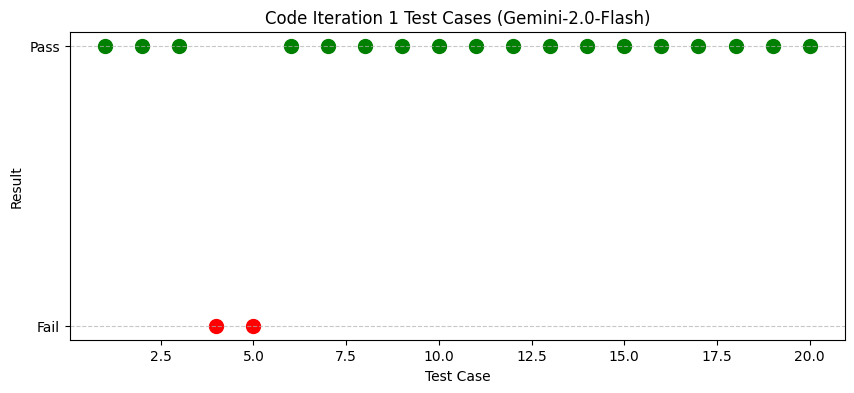

In [ ]:
# Declare lists for pass rate, results of the test cases, the passed cases and failed cases.
pass_rate = []
test_results = []
passes = []
fails = []

# Run the first iteration of code with the test cases
for i, test in enumerate(testcases):
    
    # Run code using current test case
    print("\nTest case " + str(i+1) + ":")
    llm_output = runCode(first_iteration, test["input"])
    true_value = test["output"]
    
    # If it passed
    if(llm_output == true_value):
        print("LLM Code: " + llm_output)
        print("Neural Network: " + true_value)
        print("Passed")
        test_results.append(True)
        passes.append(test)
    
    # If it failed
    else:
        print("LLM Code: " + llm_output)
        print("Neural Network: " + true_value)
        print("Failed")
        test_results.append(False)
        fails.append(test)

# Calculate pass rate
pass_rate.append(len(passes) / len(testcases))
print("\nPass rate: " + str(pass_rate[0]))

# Plot experimental results
plt.figure(figsize=(10, 4))
for i, res in enumerate(test_results):
    plt.scatter(i+1, 1 if res else 0, color='green' if res else 'red', s=100)

plt.yticks([0, 1], ['Fail', 'Pass'])
plt.xticks(range(1,21))
plt.xlabel('Test Case')
plt.ylabel('Result')
plt.title('Heuristic 1 Test Cases (Gemini-2.0-Flash)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Repeat testing loop for the remaining code iterations (Gemini)


Code Iteration 2:
def check_direction(a, b, c, d):
  val = (c - a) * (d - b)
  if val > 0:
    return "RIGHT"
  else:
    return "LEFT"

Pass rate: 0.3


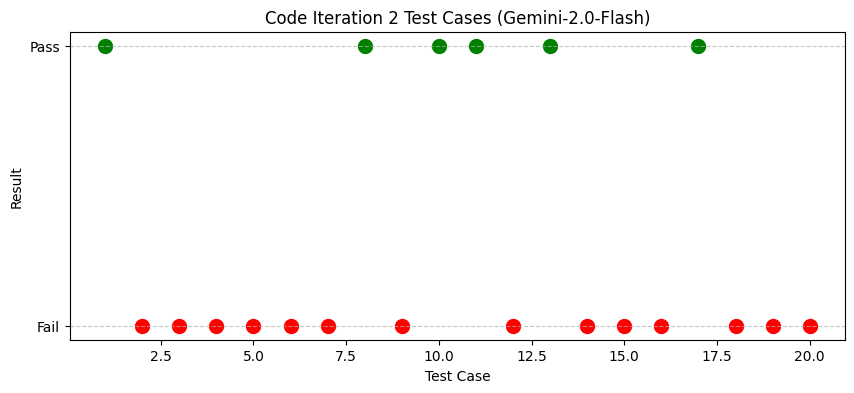


Code Iteration 3:
def check_direction(a, b, c, d):
  val = (b - d) * (c - a)
  if val > 0:
    return "RIGHT"
  elif val < 0:
    return "LEFT"
  else:
    return "LEFT"

Pass rate: 0.65


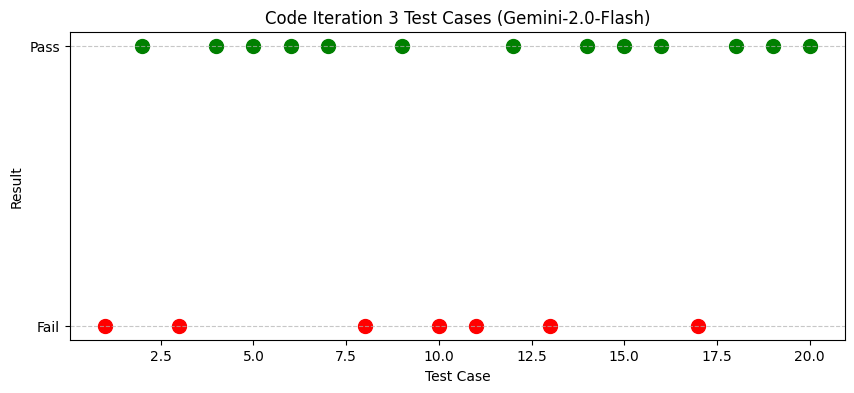


Code Iteration 4:
def check_direction(a, b, c, d):
  val = (b - d) * (c - a)
  if val > 0:
    return "RIGHT"
  elif val < 0:
    return "LEFT"
  else:
    return "RIGHT"

Pass rate: 0.7


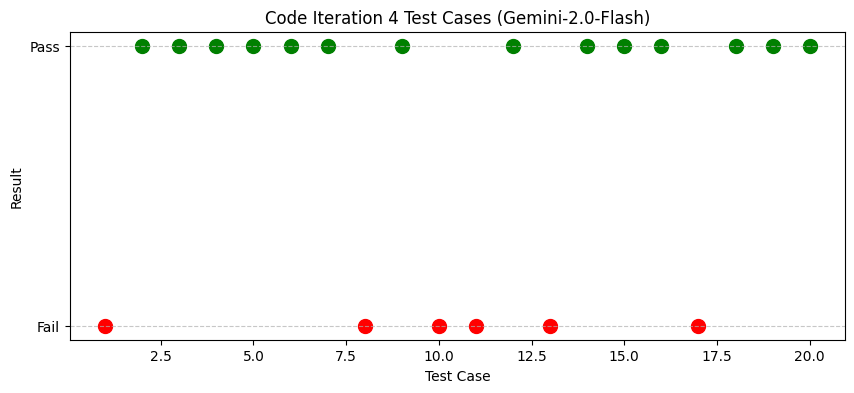


Code has not changed since the last evolution, stopping evolution process

Evolution complete, Final Iteration:
def check_direction(a, b, c, d):
  val = (b - d) * (c - a)
  if val > 0:
    return "RIGHT"
  elif val < 0:
    return "LEFT"
  else:
    return "RIGHT"


In [ ]:
code_evolution = first_iteration # Asign first iteration

# Experimental loop #
for i in range(2, n_iterations+1):
    
    previous_code = code_evolution

    # If there are no failed test cases from the previous iteration results
    if not fails:
        print("\nCode has passed all test cases, no further evolution required")
        break
    
    # Evolve code #
    generated_code = queryLLM(code_evolution, fails) 
    code_evolution = stripCode(generated_code)
    
    if code_evolution == previous_code:
        print("\nCode has not changed since the last evolution, stopping evolution process")
        break

    code_iterations.append(code_evolution) # Save newly generated code

    # Show new code
    print("\nCode Iteration " + str(i) + ":")
    print(code_evolution)
    
    # Empty test results, passes and fails lists
    test_results = []
    passes = []
    fails = []

    # Testing loop #
    for j, test in enumerate(testcases):
        
        # Run code using current test case
        #print("\nTest case " + str(j+1) + ":")
        llm_output = runCode(code_evolution, test["input"])
        true_value = test["output"]

        # If it passed
        if(llm_output == true_value):
            #print("LLM Code: " + llm_output)
            #print("Neural Network: " + true_value)
            #print("Passed")
            test_results.append(True)
            passes.append(test)
        
        # If it failed
        else:
            #print("LLM Code: " + llm_output)
            #print("Neural Network: " + true_value)
            #print("Failed")
            test_results.append(False)
            fails.append(test)

    # Calculate pass rate
    pass_rate.append(len(passes) / len(testcases))
    print("\nPass rate: " + str(pass_rate[i-1]))

    # Plot experimental results
    plt.figure(figsize=(10, 4))
    for j, res in enumerate(test_results):
        plt.scatter(j+1, 1 if res else 0, color='green' if res else 'red', s=100)

    plt.yticks([0, 1], ['Fail', 'Pass'])
    plt.xticks(range(1,21))
    plt.xlabel('Test Case')
    plt.ylabel('Result')
    plt.title('Heuristic '+ str(i) +' Test Cases (Gemini-2.0-Flash)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

print("\nEvolution complete, Final Iteration:")
print(code_evolution)

Pass rate (Gemini)

[1, 2, 3, 4]
[0.9, 0.3, 0.65, 0.7]


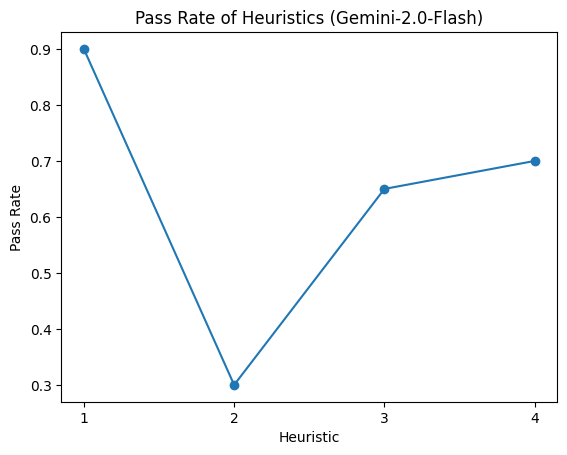

In [ ]:
# Plotting the pass rate of all the code iterations from the Gemini LLM
x = []
for i in range(len(pass_rate)):
    x.append(i+1)
#x = list(range(len(pass_rate)))  # [0, 1, 2, ..., 10]
print(x)
print(pass_rate)

plt.plot(x, pass_rate, marker='o')
plt.xlabel('Heuristic')
plt.xticks(x)
plt.ylabel('Pass Rate')
plt.title('Pass Rate of Heuristics (Gemini-2.0-Flash)')
plt.show()

Determine best heuristic

In [38]:
best_code = code_iterations[0]
best_score = pass_rate[0]

for i, code in enumerate(code_iterations):
    if pass_rate[i] > best_score:
        best_code = code
        best_score = pass_rate[i]

print("Highest scoring code:\n\n" + best_code)
print("\nWith a pass rate of: " + str(best_score))

Highest scoring code:

def check_direction(a, b, c, d):
  if d > 0:
    return "RIGHT"
  else:
    return "LEFT"

With a pass rate of: 0.9


Store all heuristics in a text file

In [ ]:
with open('cartpole-heuristics.txt', 'a') as file:
    for code in code_iterations:
        file.write(code + "\n\n")